In [1]:
import numpy as np
import scipy
import os, sys
from scipy.io import mmread, mmwrite
from time import perf_counter
from matplotlib import pyplot as plt
import pyamg
from pyamg.relaxation.smoothing import change_smoothers
from collections import namedtuple
import argparse
import pathlib
from pathlib import Path

#get the current file path
prj_dir = os.path.dirname(os.path.abspath(os.getcwd())) + '/'
case_name = 'scale3'

to_read_dir = prj_dir + f"/result/{case_name}/A/"
save_fig = True
show_fig = True
maxiter = 300
early_stop = False
tol=1e-10 # relative tolerance
postfix = 'F26-0'

print(f"to_read_dir: {to_read_dir}")


to_read_dir: e:\Dev\tiPBD//result/scale3/A/


In [2]:
def load_A_b(postfix):
    print("loading data...")
    print(f"{to_read_dir}")
    Apath = to_read_dir+f"A_{postfix}.mtx"
    print(f"Apath: {Apath}")
    if not os.path.exists(Apath):
        print(f"file {Apath} not exist")
        # sys.exit(1)
    A = scipy.io.mmread(to_read_dir+f"A_{postfix}.mtx")
    A = A.tocsr()
    A = A.astype(np.float64)
    b = np.loadtxt(to_read_dir+f"b_{postfix}.txt", dtype=np.float64)
    return A, b

A, b = load_A_b(postfix)

loading data...
e:\Dev\tiPBD//result/scale3/A/
Apath: e:\Dev\tiPBD//result/scale3/A/A_F26-0.mtx


In [3]:
x0 = np.zeros_like(b)
allres = []
tic = perf_counter()

label = "UA+CG"
print(f"Calculating {label}...")
ml18 = pyamg.smoothed_aggregation_solver(A, smooth=None, coarse_solver='pinv', max_coarse=2, max_levels=2, keep=True)
r = []
_ = ml18.solve(b, x0=x0.copy(), tol=tol, residuals=r,maxiter=maxiter, accel='cg',cycle='V')

A0 = ml18.levels[0].A
A1 = ml18.levels[1].A
Agg0 = ml18.levels[0].AggOp

Calculating UA+CG...


In [4]:
Agg0.toarray()

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]], dtype=int8)

In [5]:

path = prj_dir + "/AggOp.mtx"
print(path)
if os.path.exists(path):
    print(f"file {path} exist")
else:
    print(f"file {path} not exist")
AggOp64 = mmread(path)
AggOp64 = AggOp64.toarray()
# for i in range(10):
sumRow = np.sum(AggOp64[:,:],axis=1)
# is all row sum to 1?
print(np.allclose(sumRow,1))
sumRow

e:\Dev\tiPBD//AggOp.mtx
file e:\Dev\tiPBD//AggOp.mtx exist
True


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
def plot_residuals(data, ax, *args, **kwargs):
    title = kwargs.pop("title", "")
    linestyle = kwargs.pop("linestyle", "-")
    label = kwargs.pop("label", "")
    x = np.arange(len(data))
    ax.plot(x, data, label=label, linestyle=linestyle, *args, **kwargs)
    ax.set_title(title)
    ax.set_yscale("log")
    ax.set_xlabel("iteration")
    ax.set_ylabel("relative residual")
    ax.legend(loc="upper right")


Calculating UA+CG replace P with Agg...
Calculating UA+CG replace P with Agg...


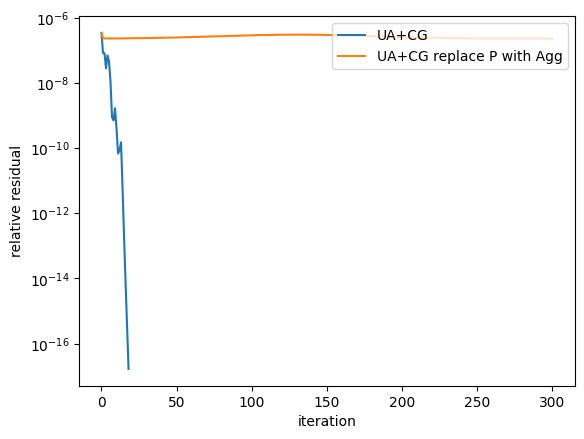

In [21]:
%matplotlib inline

label1 = "UA+CG"
print(f"Calculating {label}...")
ml1 = pyamg.smoothed_aggregation_solver(A, smooth=None, coarse_solver='pinv', max_coarse=2, max_levels=2, keep=True)
r1 = []
_ = ml1.solve(b, x0=x0.copy(), tol=tol, residuals=r1,maxiter=maxiter, accel='cg',cycle='V')



label = "UA+CG replace P with Agg"
print(f"Calculating {label}...")
ml2 = pyamg.smoothed_aggregation_solver(A, smooth=None, coarse_solver='pinv', max_coarse=2, max_levels=2, keep=True)
ml2.levels[0].P = Agg0
ml2.levels[1].P = AggOp64
r2 = []
_ = ml2.solve(b, x0=x0.copy(), tol=tol, residuals=r2,maxiter=maxiter, accel='cg',cycle='V')

fig, ax = plt.subplots()
plot_residuals(r1, ax, label=label1)
plot_residuals(r2, ax, label=label)
plt.show()